In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
rkt_df = pd.read_csv("../experiments/rkt_stack/results.csv")
rkt_df["Language"] = "Racket"
ocaml_df = pd.read_csv("../experiments/ocaml_stack/results.csv")
ocaml_df["Language"] = "OCaml"
lua_df = pd.read_csv("../experiments/lua_stack/results.csv")
lua_df["Language"] = "Lua"
raw_df = pd.concat([rkt_df, ocaml_df, lua_df])
raw_df

,Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions,Language
0,eval_31974,1,0.053416,161,20,20,Racket
1,eval_63948,1,0.052795,161,20,20,Racket
2,eval_95921,1,0.061491,161,20,20,Racket
0,eval_163180,1,0.033013,156,20,20,OCaml
1,eval_326360,1,0.029167,156,20,20,OCaml
2,eval_489539,1,0.032051,156,20,20,OCaml
0,eval_499094,1,0.141304,161,20,20,Lua
1,eval_998188,1,0.132919,161,20,20,Lua
2,eval_1497281,1,0.128261,161,20,20,Lua


In [5]:
# The Dataset column has values called eval_N. Add a new column Tokens with the value of N.
processed_df = raw_df.assign(Tokens=raw_df.Dataset.str.extract(r'eval_(\d+)').astype(int))
# Tokens is really in microbatches. Each batch has 1 item with 2048 tokens.
processed_df["Tokens"] *= 2048 
processed_df = processed_df.drop(columns=["Dataset", "Pass@k", "MinCompletions", "MaxCompletions", "NumProblems"])
# Add an Epoch column which is the row index + 1
processed_df = processed_df.reset_index().rename(columns={"index": "Epoch"})
processed_df["Epoch"] += 1
baseline_df = pd.DataFrame(
    {"Epoch": [0, 0, 0],
     "Tokens": [0, 0, 0],
     "Language": ["OCaml", "Racket", "Lua"],
     "Estimate": [0.02, 0.0503, 0.1252 ]
    })
processed_df = pd.concat([baseline_df, processed_df])
processed_df.head()

,Epoch,Tokens,Language,Estimate
0,0,0,OCaml,0.020000
1,0,0,Racket,0.050300
2,0,0,Lua,0.125200
0,1,65482752,Racket,0.053416
1,2,130965504,Racket,0.052795


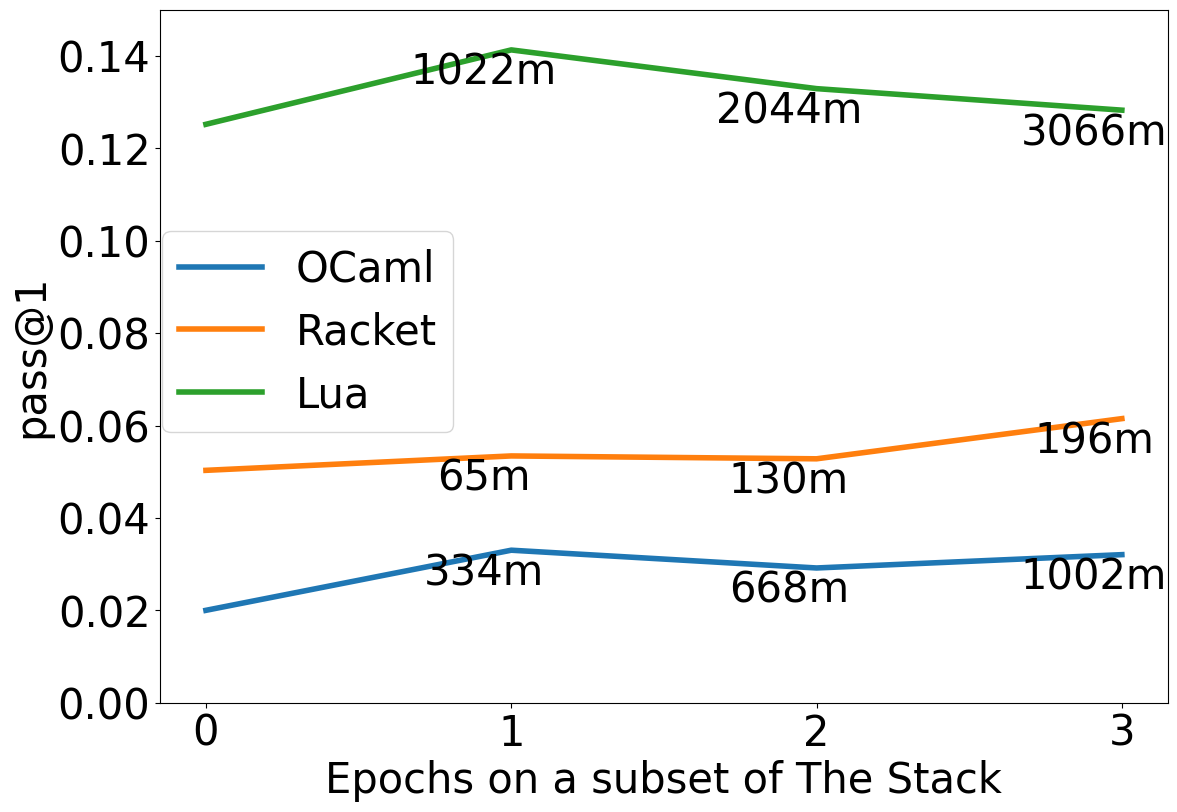

In [60]:
# A line plot of processed_df with Epoch on the x-axis and Estimate on the y-axis.
# One line per Language on a single plot.
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(111)
for lang in processed_df['Language'].unique():
    ax.plot(processed_df[processed_df['Language'] == lang]['Epoch'], processed_df[processed_df['Language'] == lang]['Estimate'], label=lang,
            linewidth=4.0)

    epochs = processed_df[processed_df['Language'] == lang]['Epoch']
    estimates = processed_df[processed_df['Language'] == lang]['Estimate']
    tokens = processed_df[processed_df['Language'] == lang]['Tokens']
    for (epoch, estimate, token) in zip(epochs, estimates, tokens):
        if epoch == 0:
            continue
        token = token // 1_000_000
        token = f"{token}m"
        ax.annotate(token, (epoch, estimate),textcoords="offset points", xytext=(-20,-25), ha='center', fontsize=30)

import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)

# X-axis ticks should be just 0, 1, 2, 3
ax.set_xticks(range(0, 4))
# y axis limit
ax.set_ylim([0, 0.15])
ax.set_xlabel('Epochs on a subset of The Stack')
ax.set_ylabel('pass@1')
# ax.set_title('Tokens vs Estimate')
ax.legend(loc= [0.002,0.39])
# Save PDF
plt.savefig("train_longer.pdf",bbox_inches='tight')
plt.show()

